custom MAPE ?

concat predicted demand be input


# Setup

In [ ]:
%pip install xgboost

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os

## Defining functions

In [3]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [4]:
def customized_MAPE(true_values, predicted_values):
    true_values, predicted_values = np.array(true_values), np.array(predicted_values)
    Mape = np.median(np.abs((true_values - predicted_values) / (true_values + 0.01)))
    return Mape

In [5]:
def load_data(train_size, test_size, force_update):
    path = 'datasets/'
    if os.path.exists(path) and (not force_update):
        pass
    else:
        urls = ['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet']
        
        for index in range(len(urls)):
            response = requests.get(urls[index])
            name = path + 'm' + str(index + 1) + '.parquet'

            with open(name, 'wb') as f:
                f.write(response.content)


    train_data = []
    test_data = []
    #train part
    for i in range(train_size):
        name = path + 'm' + str(i + 1) + '.parquet'
        data = pd.read_parquet(name)
        train_data.append(data)
    #test part
    for j in range(test_size):
        name = path + 'm' + str(j + train_size + 1) + '.parquet'
        data = pd.read_parquet(name)
        test_data.append(data)
    return train_data, test_data

In [25]:
def date_format_modifier(datas):  # Year/Month/Day
    modified_datas = []
    for data in datas:
        data['month'] = pd.DataFrame([int(date.strftime("%m")) for date in data['tpep_pickup_datetime']])
        data['tpep_pickup_datetime'] = pd.DataFrame([int(date.strftime("%d")) for date in data['tpep_pickup_datetime']])
        data = data.dropna()
        modified_datas.append(data)

    return modified_datas

In [26]:
def location_format_modifier(data):  # run after merging datasets and modifing date

    data['prev_demand'] = data.groupby(['PULocationID', 'month'])['Demand'].shift(1)

    # replace "loc_id" values with previous day's "Demand" values
    data['PULocationID'] = data.apply(lambda x: x['prev_demand'] if pd.notna(x['prev_demand']) else None, axis=1)

    # drop the temporary "prev_demand" column
    data.drop(columns=['prev_demand'], inplace=True)
    data = data.dropna()

    return data

In [27]:
def grouping_by(data, group_list):
    data_grouped = data.groupby(group_list, as_index = False)['extra'].count()
    data_grouped = data_grouped.rename(columns={'extra' : 'Demand'})

    return data_grouped

In [28]:
def clearing_data_noise(datas, months):
    clean_datas = []
    for index in range(len(datas)):
        month = months[index]
        data = datas[index]

        clean_data = data[[int(date.strftime("%m")) == month for date in data['tpep_pickup_datetime']]]
        clean_data = clean_data.dropna()
        clean_datas.append(clean_data)
    return clean_datas

In [40]:
def grid_search(model, test_parameters, train_data, cv = None):
    gs = GridSearchCV(estimator = model, param_grid = test_parameters, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs = -1)
    gs.fit(train_data[train_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [41]:
def point_predict(model, train_data, test_data):

    model.fit(train_data[train_list], train_data['Demand'])


    yhat_train = model.predict(train_data[train_list])
    yhat_test = model.predict(test_data[train_list])

    return yhat_train, yhat_test

In [31]:
def point_predict_visualizer(train_data, test_data, yhat_train, yhat_test):

    predicted_train_df = train_data.copy(deep = True)
    predicted_test_df = test_data.copy(deep = True)
    predicted_train_df['Predicted'] = yhat_train
    predicted_test_df['Predicted'] = yhat_test


    train_data = train_data.groupby('day_number')['Demand'].sum()
    test_data = test_data.groupby('day_number')['Demand'].sum()

    predicted_train_df = predicted_train_df.groupby('day_number')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_number')['Predicted'].sum()



    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

In [32]:
def concating_data(datas):
    data_combined = pd.concat(datas, axis=0)
    return data_combined

In [61]:
def evaluation(model_name, train_data, test_data, yhat_train, yhat_test):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], yhat_train)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], yhat_train)
    evaluate(customized_MAPE, 'MAPE', train_data['Demand'], yhat_train)

    print(f'{model_name} test scores:')


    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], yhat_test)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], yhat_test)
    evaluate(customized_MAPE, 'MAPE', test_data['Demand'], yhat_test)


In [34]:
def sort_metrics_values(metrics_values):
    metrics_train_values  = metrics_values['train']
    metrics_test_values = metrics_values['test']

    sorted_train_metrics = sorted(metrics_train_values, key=lambda x: x[1]['RMSE'], reverse = True)
    sorted_test_metrics = sorted(metrics_test_values, key=lambda x: x[1]['RMSE'], reverse = True)

    sorted_metrics_values = {'train': sorted_train_metrics, 'test': sorted_test_metrics}
    return sorted_metrics_values

In [42]:
def evaluate_each_location(fitted_model, train_data, test_data):
    metrics_values = {'train' : [], 'test': []}
    for loc_id in range(loc_id_num):
        sample_train_data = train_data[train_data['PULocationID'] == loc_id]
        sample_test_data = test_data[test_data['PULocationID'] == loc_id]
        if len(sample_train_data) != 0:
            yhat_train_sample = fitted_model.predict(sample_train_data[train_list])
            metrics_values['train'].append([loc_id, {'RMSE' : np.sqrt(mean_squared_error(sample_train_data["Demand"], yhat_train_sample)),
                                                      'MAE' : mean_absolute_error(sample_train_data["Demand"], yhat_train_sample)}])
        if len(sample_test_data) != 0:
            yhat_test_sample = fitted_model.predict(sample_test_data[train_list])
            metrics_values['test'].append([loc_id, {'RMSE' : np.sqrt(mean_squared_error(sample_test_data["Demand"], yhat_test_sample)),
                                                      'MAE' : mean_absolute_error(sample_test_data["Demand"], yhat_test_sample)}])
    return sort_metrics_values(metrics_values)

In [36]:
def get_locations_mean_demand(locations_id, data):
    sum_demands = []
    for location_id in locations_id:
        sum_demands.append({location_id : data[data['PULocationID'] == location_id]['Demand'].mean()})
    return sum_demands

In [52]:
def day_of_year_modifier(data):
    data['day_number'] = 0

    # Loop over each row in the DataFrame
    for index, row in data.iterrows():
        # Get the day and month values from the current row
        day = int(row['tpep_pickup_datetime'])
        month = int(row['month'])
        
        # Calculate the day number for the current row using datetime
        date = datetime.datetime(year=2023, month=month, day=day)
        day_number = (date - datetime.datetime(year=2023, month=1, day=1)).days + 1
        
        # Store the day number in the 'day_number' column for the current row
        data.at[index, 'day_number'] = day_number
    return data

# Main

## initialization and loading dataset

In [39]:
group_list = ['tpep_pickup_datetime', 'month', 'PULocationID']
train_list = ['day_number', 'PULocationID']
loc_id_num = 266
train_size = 3
test_size = 1

In [20]:
train_data, test_data = load_data(train_size, test_size, force_update = False)

## Preprocessing

In [21]:
train_data = clearing_data_noise(train_data, [1,2,3])
test_data = clearing_data_noise(test_data, [4])

In [22]:
train_date_modified = date_format_modifier(train_data)
test_date_modified = date_format_modifier(test_data)

In [23]:
train_data = concating_data(train_date_modified)
test_data = concating_data(test_date_modified)

In [43]:
train_grouped = grouping_by(train_data, group_list)
test_grouped = grouping_by(test_data, group_list)

In [44]:
train_loc_modified = location_format_modifier(train_grouped)
test_loc_modified = location_format_modifier(test_grouped)

In [ ]:
modified_train = day_of_year_modifier(train_loc_modified)
modified_test = day_of_year_modifier(test_loc_modified)

## **Linear Regression**

#### Point based prediction

##### Grid search to find best hyper parameters

In [73]:
model = Ridge()
best_params, best_score = grid_search(model, {'alpha':[1, 10, 100, 1000, 1000]}, modified_train, cv = 5)
print(best_params, best_score)

{'alpha': 1000} -236.85918766054436


In [74]:
model = Ridge(**best_params)
yhat_train, yhat_test = point_predict(model, modified_train, modified_test)

##### Visualization

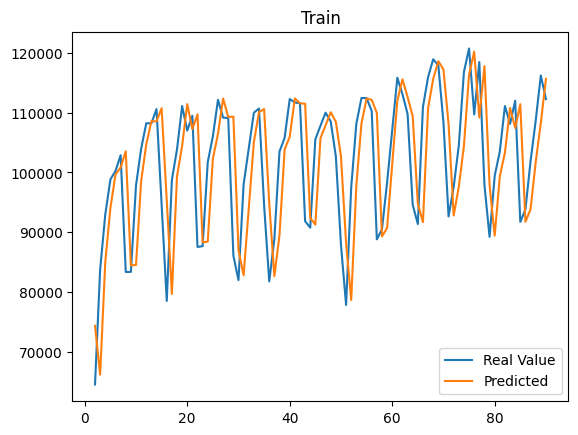

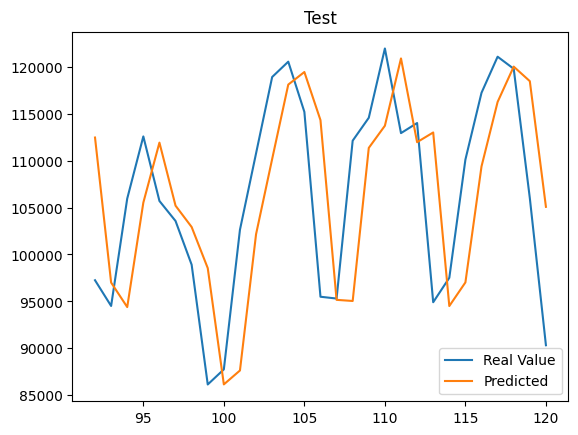

In [58]:
point_predict_visualizer(modified_train, modified_test, yhat_train, yhat_test)

##### Evaluation

In [62]:
evaluation('Ridge Regression', modified_train, modified_test, yhat_train, yhat_test)  # for whole data

Ridge Regression train scores:
MAE : 84.28222606228215
MSE : 56133.74725000298
MAPE : 1.3447545787202069
Ridge Regression test scores:
MAE : 81.24264214440676
MSE : 51543.18693751679
MAPE : 0.8864822078368113


In [75]:
sorted_metrics_values = evaluate_each_location(model, modified_train, modified_test)  # for each location

In [76]:
sorted_metrics_values['train'][:10]

[[234, {'RMSE': 148.88991421806773, 'MAE': 102.3316195760478}],
 [241, {'RMSE': 129.5078703967367, 'MAE': 127.03215515346822}],
 [226, {'RMSE': 120.60743560706435, 'MAE': 90.87747755541484}],
 [206, {'RMSE': 112.47165239086243, 'MAE': 94.9271925694398}],
 [223, {'RMSE': 112.41833451649839, 'MAE': 84.7105861407098}],
 [191, {'RMSE': 108.86595505419292, 'MAE': 65.80899674243919}],
 [229, {'RMSE': 108.6985083488548, 'MAE': 80.4857003388259}],
 [207, {'RMSE': 108.60549026549972, 'MAE': 89.12723252728513}],
 [225, {'RMSE': 108.51099708239849, 'MAE': 82.50451117806858}],
 [195, {'RMSE': 107.5236015243459, 'MAE': 82.93917182686928}]]

In [77]:
modified_train['Demand'].mean()

469.0255772082186

In [78]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_train)

[{234: 318.3333333333333},
 {241: 229.0},
 {226: 163.0},
 {206: 166.33333333333334},
 {223: 160.66666666666666},
 {191: 245.66666666666666},
 {229: 194.0},
 {207: 277.5},
 {225: 147.75},
 {195: 152.0}]

In [79]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_test)

[{244: 38.0},
 {222: 184.0},
 {151: 40.0},
 {177: 110.5},
 {165: 78.5},
 {149: 58.0},
 {210: 119.0},
 {254: 167.0},
 {111: 170.75},
 {251: 168.0}]

## **Gradient Boosting Regressor**

#### Point based prediction

##### Grid search to find best hyper parameters

In [64]:
dtrain_reg = xgb.DMatrix(modified_train[train_list].values, modified_train['Demand'].values, enable_categorical=True)
dtest_reg = xgb.DMatrix(modified_test[train_list].values, modified_test['Demand'].values, enable_categorical=True)

In [80]:
param_test = {'max_depth':range(2,10,2), 'min_child_weight':range(1,6,2)}

params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'n_estimators':140, 'learning_rate':0.1, 'max_depth':5,
         'min_child_weight':1, 'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8, 'seed':27}

best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'max_depth': 2, 'min_child_weight': 5} -238.60198873503435


In [81]:
params.update(best_params)
param_test = {'gamma':[i/10.0 for i in range(0,5)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'gamma': 0.0} -238.60198873503435


In [85]:
params.update(best_params)
param_test = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'colsample_bytree': 0.6, 'subsample': 0.9} -237.0204546297031


In [87]:
params.update(best_params)
param_test = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'reg_alpha': 1} -237.02005974356038


In [90]:
params.update(best_params)
param_test = {'n_estimators':list(range(1000, 5001, 500)), 'learning_rate':[0.01]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.01, 'n_estimators': 1500} -236.59626847393665


In [95]:
params.update(best_params)
param_test = {'n_estimators':list(range(15000, 20001, 500)), 'learning_rate':[0.001]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.001, 'n_estimators': 15000} -236.53642284774014


##### Training

In [65]:

#params.update(best_params)
params = {'learning_rate': 0.001, 'n_estimators': 15000, 'reg_alpha': 1, 'colsample_bytree': 0.6, 
          'subsample': 0.9, 'gamma': 0.0, 'max_depth': 2, 'min_child_weight': 5}
model = xgb.XGBRegressor(**params)
yhat_train, yhat_test = point_predict(model, modified_train, modified_test)

##### Visualization

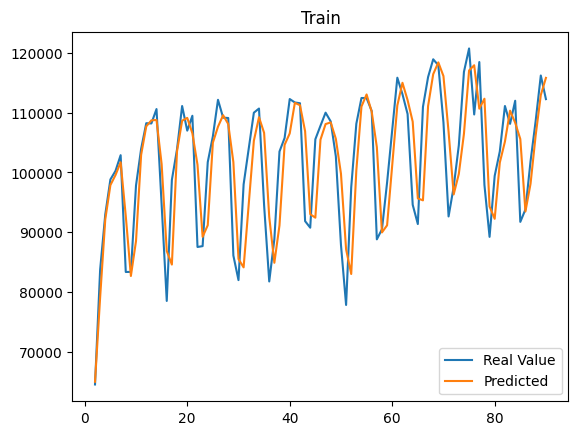

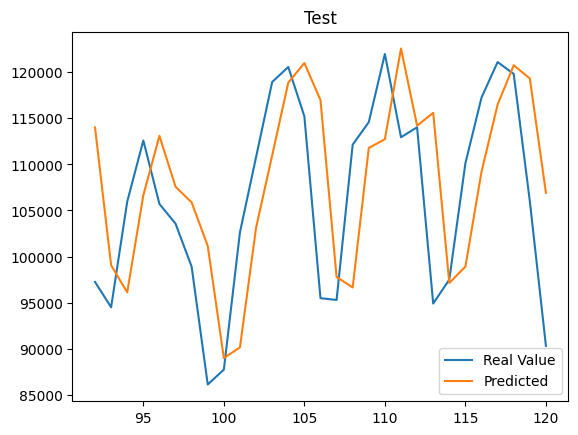

In [66]:
point_predict_visualizer(modified_train, modified_test, yhat_train, yhat_test)

##### Evaluation

In [67]:
evaluation('Random Forest Regressor', modified_train, modified_test, yhat_train, yhat_test)  # for whole data

Random Forest Regressor train scores:
MAE : 79.38545367265557
MSE : 49328.257669536295
MAPE : 0.7688803008164282
Random Forest Regressor test scores:
MAE : 80.82238415174173
MSE : 51235.62817499878
MAPE : 0.7363331040055321


In [68]:
sorted_metrics_values = evaluate_each_location(model, modified_train, modified_test)  # for each location

In [69]:
sorted_metrics_values['train'][:10]

[[234, {'RMSE': 153.36940931100642, 'MAE': 103.45976257324219}],
 [218, {'RMSE': 129.08644604654685, 'MAE': 73.8827412923177}],
 [241, {'RMSE': 127.01971013733548, 'MAE': 101.67916870117188}],
 [191, {'RMSE': 114.7712669448279, 'MAE': 67.29306284586589}],
 [223, {'RMSE': 101.25148323271135, 'MAE': 77.24301656087239}],
 [259, {'RMSE': 97.10957912447165, 'MAE': 65.94297409057617}],
 [229, {'RMSE': 97.1026845074878, 'MAE': 76.38224411010742}],
 [195, {'RMSE': 96.88022820725763, 'MAE': 80.02172342936198}],
 [226, {'RMSE': 96.836271134135, 'MAE': 74.81925964355469}],
 [99, {'RMSE': 91.20537465310092, 'MAE': 68.18453407287598}]]

In [70]:
train_loc_modified['Demand'].mean()

469.0255772082186

In [71]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_train)

[{234: 318.3333333333333},
 {218: 271.8333333333333},
 {241: 229.0},
 {191: 245.66666666666666},
 {223: 160.66666666666666},
 {259: 293.75},
 {229: 194.0},
 {195: 152.0},
 {226: 163.0},
 {99: 117.0}]

In [72]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_test)

[{244: 38.0},
 {222: 184.0},
 {177: 110.5},
 {151: 40.0},
 {165: 78.5},
 {111: 170.75},
 {210: 119.0},
 {254: 167.0},
 {193: 115.0},
 {251: 168.0}]